# Walmart Sales Forecasting

**Business Problem:** Forecasting the weekly sales of each Store and respective department for the time period (2012-11-02 to 2013-07-26) using the historical data given,

Data availability <br>
The data is available in four different files - Train, Test, features, Stores

**Approach**<br>

**1 Importing the libraries and dataset** <br>
**2 Preparing the combination of the dataset** <br>
**3 Part 1 - Regression Forecasting** <br>
> - Data audits
> - Data preparation
> > - Finding Numerical and Categorical variables
> > - Handling Missing and Outliers 
> > - Handling the categorical variables
> - Exploratory Analysis
> > - Sales vs Stores/Dept/Holidays
> > - Correlation of Xs with th Sales
> > - Coefficient of variance
> - Feature Reduction
> > - Using Random Forest 
> - Train and Test split
> - Model Implementation
> > - Random Forest
> > - XGBoost
> - Forecasting using the Regression model

**4 Part 2 - Arima model (auto arima)**
> - Preparing Exogenous variable (Markdown)
> - Preparing separate array for each Store
> - Preparing separate array for each Dept
> - Preparing Train and Test for evaluation
> - Model Implementation
> - Forecasting

### ----------------------------------------------------------------------------------------------------------------------------

Importing the libraries

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
#import pandas_profiling
from sklearn.metrics import mean_squared_error

In [2]:
import time
import warnings
import itertools
import statsmodels.api as sm
import sys
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
start_time_1 = time.time()

**Importing the Datasets**

In [4]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_out = pd.read_csv('sampleSubmission.csv')

**Preparing the combination of datasets**

In [5]:
features['Date'] = pd.to_datetime(features['Date'],format='%Y-%m-%d')
train['Date'] = pd.to_datetime(train['Date'],format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'],format='%Y-%m-%d')

In [6]:
train.columns;

In [7]:
features.columns;

In [8]:
stores.columns;

In [9]:
comb_train = pd.merge(train,features,how='inner',on=['Date','Store'])
comb_train = pd.merge(comb_train,stores,how='inner',on='Store')

comb_test = pd.merge(test,features,how='inner',on=['Date','Store'])
comb_test = pd.merge(comb_test,stores,how='inner',on='Store')

In [10]:
comb_train.columns;

In [11]:
comb_train.shape, train.shape, features.shape, stores.shape

((421570, 17), (421570, 5), (8190, 12), (45, 3))

In [12]:
comb_test.shape, test.shape, features.shape, stores.shape

((115064, 16), (115064, 4), (8190, 12), (45, 3))

In [13]:
comb_train;

In [14]:
#comb_train.to_excel('comb_train.xlsx')

### ----------------------------------------------------------------------------------------------------------------------------

## Part I - Forecasting using Regression

In [15]:
comb_train; comb_test;

**Data audit**

In [16]:
comb_train.describe().T[['count','mean','std']]

,count,mean,std
Store,421570.0,22.200546,12.785297
Dept,421570.0,44.260317,30.492054
Weekly_Sales,421570.0,15981.258123,22711.183519
Temperature,421570.0,60.090059,18.447931
Fuel_Price,421570.0,3.361027,0.458515
MarkDown1,150681.0,7246.420196,8291.221345
MarkDown2,111248.0,3334.628621,9475.357325
MarkDown3,137091.0,1439.421384,9623.078290
MarkDown4,134967.0,3383.168256,6292.384031
MarkDown5,151432.0,4628.975079,5962.887455


In [17]:
comb_test.describe().T[['count','mean','std']]

,count,mean,std
Store,115064.0,22.238207,12.809930
Dept,115064.0,44.339524,30.656410
Temperature,115064.0,53.941804,18.724153
Fuel_Price,115064.0,3.581546,0.239442
MarkDown1,114915.0,7689.216439,10698.760716
MarkDown2,86437.0,3734.051729,8323.495014
MarkDown3,105235.0,2403.088666,13767.939313
MarkDown4,102176.0,3356.219071,7570.501545
MarkDown5,115064.0,3922.681189,19445.150745
CPI,76902.0,176.961347,41.239967


#### Data Preparation

Finding the Numerical and Catagorical variables

In [18]:
comb_test.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday_x', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')

In [19]:
(comb_train.IsHoliday_y == comb_train.IsHoliday_x).value_counts()

True    421570
dtype: int64

In [20]:
#Comb Train
num_var_comb_train=['Weekly_Sales','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Size']
cat_var_comb_train=['IsHoliday_x','Type','Dept']
comb_train_num=comb_train[num_var_comb_train]
comb_train_cat=comb_train[cat_var_comb_train]
#Comb Test
num_var_comb_test=['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Size']
cat_var_comb_test=['IsHoliday_x','Type','Dept']
comb_test_num=comb_test[num_var_comb_test]
comb_test_cat=comb_test[cat_var_comb_test]

Handling the missing values

In [21]:
comb_train.count()

Store           421570
Dept            421570
Date            421570
Weekly_Sales    421570
IsHoliday_x     421570
Temperature     421570
Fuel_Price      421570
MarkDown1       150681
MarkDown2       111248
MarkDown3       137091
MarkDown4       134967
MarkDown5       151432
CPI             421570
Unemployment    421570
IsHoliday_y     421570
Type            421570
Size            421570
dtype: int64

In [22]:
def outlier_miss_treat(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    x = x.fillna(0)
    return x

comb_train_num = comb_train_num.apply(outlier_miss_treat)
comb_test_num = comb_test_num.apply(outlier_miss_treat)#imputing the zero for missing markdown

In [23]:
def miss_treat_cat(x):
    x = x.fillna(x.mode())
    return x

comb_train_cat = comb_train_cat.apply(miss_treat_cat)
comb_test_cat = comb_test_cat.apply(miss_treat_cat)

Encoding the catagorical variables

In [24]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [25]:
for c_feature in comb_train_cat:
    comb_train_cat[c_feature]=comb_train_cat[c_feature].astype('category')
    comb_train_cat=create_dummies(comb_train_cat,c_feature)
for c_feature in comb_test_cat:
    comb_test_cat[c_feature]=comb_test_cat[c_feature].astype('category')
    comb_test_cat=create_dummies(comb_test_cat,c_feature)

In [26]:
comb_test_cat;

In [27]:
Train = pd.concat([comb_train_num, comb_train_cat],axis=1)
Test = pd.concat([comb_test_num, comb_test_cat], axis=1)

Preparing the X and Y

In [28]:
X_train = Train[Train.columns.difference(['Weekly_Sales'])]
Y_train = Train[['Weekly_Sales']]

In [29]:
X_train.shape, Y_train.shape, Test.shape

((421570, 93), (421570, 1), (115064, 93))

In [30]:
X_train;Test;

**Exploratory Analysis**

Store vs Sales

In [31]:
s_s = comb_train.groupby(by=['Store'])
s_s = s_s[['Weekly_Sales']].sum().add_prefix('SumOf_') 

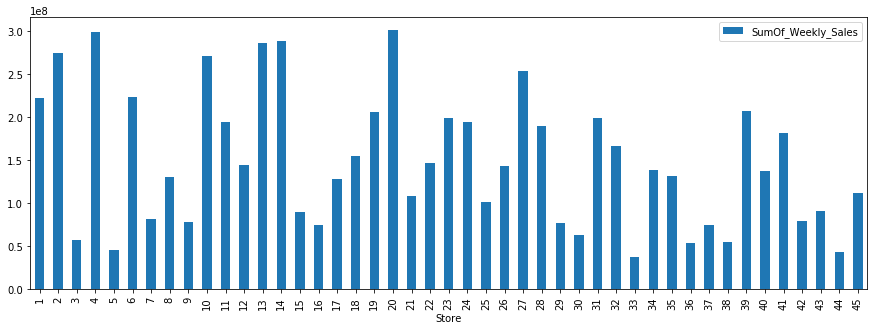

In [32]:
s_s.plot(kind='bar',figsize=(15,5))

Dept vs Weekly sales

In [33]:
d_s = comb_train.groupby(by=['Dept'])
d_s = d_s[['Weekly_Sales']].sum().add_prefix('SumOf_') 

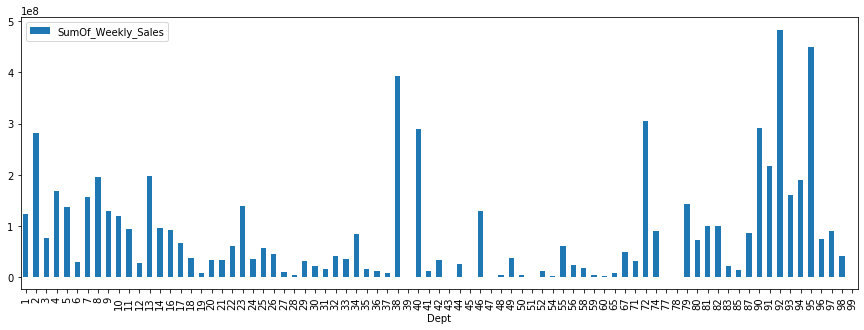

In [34]:
d_s.plot(kind='bar',figsize=(15,5))

Correlation of Sales and Xs

In [35]:
comb_train.corr();

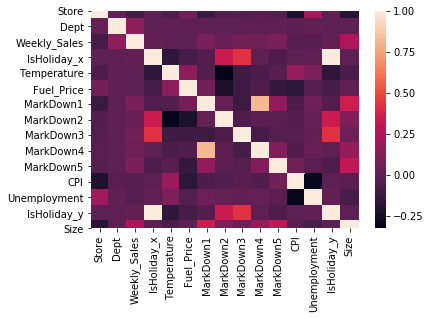

In [36]:
sns.heatmap(comb_train.corr())

from the above the heat map it seems there is multicollinearity between the Xs

In [37]:
X_train.columns

Index(['CPI', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14', 'Dept_16',
       'Dept_17', 'Dept_18', 'Dept_19', 'Dept_2', 'Dept_20', 'Dept_21',
       'Dept_22', 'Dept_23', 'Dept_24', 'Dept_25', 'Dept_26', 'Dept_27',
       'Dept_28', 'Dept_29', 'Dept_3', 'Dept_30', 'Dept_31', 'Dept_32',
       'Dept_33', 'Dept_34', 'Dept_35', 'Dept_36', 'Dept_37', 'Dept_38',
       'Dept_39', 'Dept_4', 'Dept_40', 'Dept_41', 'Dept_42', 'Dept_43',
       'Dept_44', 'Dept_45', 'Dept_46', 'Dept_47', 'Dept_48', 'Dept_49',
       'Dept_5', 'Dept_50', 'Dept_51', 'Dept_52', 'Dept_54', 'Dept_55',
       'Dept_56', 'Dept_58', 'Dept_59', 'Dept_6', 'Dept_60', 'Dept_65',
       'Dept_67', 'Dept_7', 'Dept_71', 'Dept_72', 'Dept_74', 'Dept_77',
       'Dept_78', 'Dept_79', 'Dept_8', 'Dept_80', 'Dept_81', 'Dept_82',
       'Dept_83', 'Dept_85', 'Dept_87', 'Dept_9', 'Dept_90', 'Dept_91',
       'Dept_92', 'Dept_93', 'Dept_94', 'Dept_95', 'Dept_96', 'Dept_97',
       'Dept_98', 'Dept_99', 'Fuel_Price', 'IsHolida

In [38]:
md = X_train[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
md_test = Test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]

In [39]:
X_train['Markdown_mean'] = (md.iloc[:,0]+md.iloc[:,1]+md.iloc[:,2]+md.iloc[:,3]+md.iloc[:,4])/5
Test['Markdown_mean'] = (md_test.iloc[:,0]+md_test.iloc[:,1]+md_test.iloc[:,2]+md_test.iloc[:,3]+md_test.iloc[:,4])/5

In [40]:
X_train.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace=True)
Test.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace=True)

Correlation of Sales with the Markdown

In [41]:
Y_train.corrwith(X_train.Markdown_mean)

Weekly_Sales    0.064186
dtype: float64

Checking the Coefficient of variation

In [42]:
np.std(X_train.CPI)/np.mean(X_train.CPI)

0.22868355663381298

In [43]:
np.std(X_train.Temperature)/np.mean(X_train.Temperature)

0.304405942283764

In [44]:
np.std(X_train.Unemployment)/np.mean(X_train.Unemployment)

0.23359589146704643

In [45]:
Test;

#### Feature Reduction

Feature Importances using the Random Forest

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [47]:
start_time = time.time()
pargrid_ada = {'n_estimators': [40],
               'max_depth':[10]}

data_rf = GridSearchCV(estimator=RandomForestRegressor(), 
                        param_grid=pargrid_ada, 
                        cv=2,n_jobs=-1)
data_rf.fit(X_train, Y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 204.07167220115662 seconds ---


In [48]:
data_rf.best_params_

{'max_depth': 10, 'n_estimators': 40}

In [49]:
best_rf = RandomForestRegressor(max_depth= 10, n_estimators= 40)
best_rf.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
feat_imp = pd.concat([pd.Series(X_train.columns),pd.Series(best_rf.feature_importances_)],axis=1).sort_values(by=1,ascending=False) #.to_excel('rf_ft_imp.xlsx')

In [51]:
feat_imp = list(feat_imp[feat_imp[1]>0][0])

In [52]:
X_train_all = X_train.copy()
X_final = X_train_all[feat_imp]
Test_final = Test[feat_imp]
X_final.shape,Y_train.shape,Test_final.shape

((421570, 20), (421570, 1), (115064, 20))

 --------------------------------------------------- End of Data Prep for Regression ---------------------------------------------------------------

Split the train data into Train and Test

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_train, test_size = 0.6, random_state = 123)

### Regression Model Implementation

We use Random Forest and XGBoost models and choose the one which gives better accuracy

**Random Forest**

In [54]:
start_time = time.time()
pargrid_ada = {'n_estimators': [100],
               'max_depth':[10]}

rf = GridSearchCV(estimator=RandomForestRegressor(), 
                        param_grid=pargrid_ada, 
                        cv=3,n_jobs=-1)
rf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 136.88682913780212 seconds ---


In [55]:
rf.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [56]:
y_pred_rf_test = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)

In [57]:
accuracy_rf= round(rf.score(X_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%accuracy_rf)

Accuracy: 67 % 



**XGBoost**

In [58]:
import xgboost

In [59]:
start_time = time.time()
pargrid_xg = {'n_estimators': [100],
               'max_depth':[10]}

gscv_xg = GridSearchCV(estimator=xgboost.XGBRegressor(), 
                        param_grid=pargrid_xg, 
                        cv=3,n_jobs=-1)

data_xg=gscv_xg.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

[11:12:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- 102.65887188911438 seconds ---


In [60]:
y_pred_xg_test = data_xg.predict(X_test)
y_pred_xg_train = data_xg.predict(X_train)

In [61]:
accuracy_xg = round(data_xg.score(X_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%accuracy_xg)

Accuracy: 76 % 



In [62]:
print("--- %s seconds ---" % (time.time() - start_time_1))

--- 601.0953805446625 seconds ---


**Model Evaluation**

In [69]:
def mod_eva(t1, t3):
    #Mean Absolute Percentage Error 
    print("MAPE values for actual training :")
    MAPE_train = np.mean(np.abs(t3 - t1)/t3)
    print(MAPE_train)
    
    #Root Mean Squared error
    print("\nRMSE values for actual training :")
    RMSE_train = np.sqrt(mean_squared_error(t3,t1))
    print(RMSE_train)

In [78]:
t3 = y_train.reset_index()

---

Since the accuracy of the XGBoost model is better than the Random Forest model. We will choose the XGBoost.

**Forecasting using XGBoost**

In [63]:
result_reg_forecast = pd.DataFrame({"Store_Dept_Date": test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
              "Weekly_Sales": data_xg.predict(Test_final) })

In [65]:
result_reg_forecast.head()

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,11756.886719
1,1_1_2012-11-09,43366.390625
2,1_1_2012-11-16,11756.886719
3,1_1_2012-11-23,11756.886719
4,1_1_2012-11-30,11756.886719


In [66]:
result_reg_forecast.tail()

,Store_Dept_Date,Weekly_Sales
115059,45_98_2013-06-28,19288.878906
115060,45_98_2013-07-05,5745.884277
115061,45_98_2013-07-12,68619.367188
115062,45_98_2013-07-19,19288.878906
115063,45_98_2013-07-26,19288.878906


In [ ]:
#result_reg_forecast.to_excel('Result_Regression_Forecast.xlsx')

### -------------------------------------------- End of Regression Forecasting ----------------------------------

## Part II - ARIMA model using auto arima

In [86]:
comb_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')

**Preparing the Exogenous variable Markdown**

for train

In [87]:
comb_train_ar = comb_train[['Date','Store','Dept','Weekly_Sales','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']]

In [88]:
md = comb_train_ar[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
comb_train_ar['Markdown_mean'] = (md.iloc[:,0]+md.iloc[:,1]+md.iloc[:,2]+md.iloc[:,3]+md.iloc[:,4])/5

In [89]:
comb_train_ar.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace=True)

In [90]:
comb_train_ar.fillna(0,inplace=True)

In [91]:
comb_train_ar.Markdown_mean.value_counts();

In [92]:
# Binning 
comb_train_ar['Markdown_bin'] = pd.qcut(comb_train_ar.Markdown_mean,10, labels=False,duplicates='drop')

In [93]:
comb_train_ar.drop(columns=['Markdown_mean'],inplace=True)

In [94]:
comb_train_ar.head(3)

,Date,Store,Dept,Weekly_Sales,Markdown_bin
0,2010-02-05,1,1,24924.50,0
1,2010-02-05,1,2,50605.27,0
2,2010-02-05,1,3,13740.12,0


for test

In [95]:
comb_test_ar = comb_test[['Date','Store','Dept','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']]

In [96]:
md = comb_test_ar[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
comb_test_ar['Markdown_mean'] = (md.iloc[:,0]+md.iloc[:,1]+md.iloc[:,2]+md.iloc[:,3]+md.iloc[:,4])/5

In [97]:
comb_test_ar.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace=True)

In [98]:
comb_test_ar.fillna(0,inplace=True)

In [99]:
comb_test_ar.Markdown_mean.value_counts();

In [100]:
# Binning 
comb_test_ar['Markdown_bin'] = pd.qcut(comb_test_ar.Markdown_mean,10, labels=False,duplicates='drop')

In [101]:
comb_test_ar.drop(columns=['Markdown_mean'],inplace=True)

In [102]:
comb_test_ar.head(3)

,Date,Store,Dept,Markdown_bin
0,2012-11-02,1,1,4
1,2012-11-02,1,2,4
2,2012-11-02,1,3,4


In [103]:
comb_test_ar.shape[0]/(39*45)

65.56353276353276

**Preparing the separate array for each Store**

for train

In [104]:
comb_train_ar = comb_train_ar.sort_values(by=['Store','Dept'])

In [105]:
S = [None] * len(comb_train_ar.Store.unique())
for i in comb_train_ar.Store.unique():
    S[i-1] = comb_train_ar[comb_train_ar.Store == i]

for test

In [106]:
comb_test_ar = comb_test_ar.sort_values(by=['Store','Dept'])

In [107]:
S_test = [None] * len(comb_test_ar.Store.unique())
for i in comb_test_ar.Store.unique():
    S_test[i-1] = comb_test_ar[comb_test_ar.Store == i]

**Preparing the separate array of each Store with each Dept**

for train

In [108]:
D=[None]*len(S)
for i in range(0,len(D)):
        D[i]=([None] * 99) #dept ranges till 99

In [109]:
for i in range(0,len(S)):
    for j in range(0,len(D[i])+1):
        if j!=99:
            D[i][j] = S[i][S[i].Dept==j+1]

for test

In [110]:
D_test=[None]*len(S_test)
for i in range(0,len(D_test)):
        D_test[i]=([None] * 99) #Dept ranges till 99

In [111]:
for i in range(0,len(S_test)):
    for j in range(0,len(D_test[i])+1):
        if j!=99:
            D_test[i][j] = S_test[i][S_test[i].Dept==j+1]

In [112]:
print(D[0][0].shape, D_test[0][0].shape)

(143, 5) (39, 4)


In [113]:
D[0][0].head(3)

,Date,Store,Dept,Weekly_Sales,Markdown_bin
0,2010-02-05,1,1,24924.50,0
73,2010-02-12,1,1,46039.49,0
145,2010-02-19,1,1,41595.55,0


In [114]:
D_test[0][0].head(3)

,Date,Store,Dept,Markdown_bin
0,2012-11-02,1,1,4
71,2012-11-09,1,1,5
142,2012-11-16,1,1,4


**Preparing the array Train and Test for every Dept of each Store** 

(Used for evaluating)

In [115]:
np.min(D[0][0]['Date']),np.max(D[0][0]['Date'])  #Date range

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [116]:
train_data=[None]*len(S)
for i in range(0,len(D)):
        train_data[i]=([None] * 99)
test_data=[None]*len(S)
for i in range(0,len(D)):
        test_data[i]=([None] * 99)

In [117]:
for i in range(0,len(D)):
    for j in range(0,99):
        train_data_size = math.floor(len(D[i][j])*0.7)
        test_data_size = math.ceil(len(D[i][j])*0.3)
        data = D[i][j][['Date','Weekly_Sales']]
        data = data.set_index(data.Date)[['Weekly_Sales']]
        train_data[i][j] = data.head(train_data_size)
        test_data[i][j]  = data.tail(test_data_size)

In [118]:
train_data[0][0].shape,test_data[0][0].shape

((100, 1), (43, 1))

In [119]:
train_data[0][0].tail(1)

,Weekly_Sales
Date,
2011-12-30,23350.88


In [120]:
test_data[0][0].head(1)

,Weekly_Sales
Date,
2012-01-06,16567.69


### Auto arima 

In [121]:
from pmdarima.arima import auto_arima

In [122]:
l_auto = []
pred_out = pd.DataFrame()
def auto_mod_all(D,store,dept,exog,exog_test,pdq,seasonal_pdq):
    pred_dict = {'Store':store,'Dept':dept,'Pred':['x']*39,'Week_no':range(1,40)}
    pred_out_mod = pd.DataFrame(pred_dict,index=range(0,39))
    for X in [1,2]:
        try:       
            if X == 1: #For good data
                print('1',end='\r')
                auto_model = auto_arima(D,exogenous=exog,#n_fits=50,
                    start_p=3,d=1,start_q=0,max_p=5,max_d=2,max_q=3,
                    start_P=1,D=0,start_Q=0,max_P=3,max_D=1,max_Q=1,
                    m=52,seasonal=False,stationary=False,information_criterion='aic',alpha=0.05,#n_jobs=-1,
                    trace=False, suppress_warnings=False) #error_action='ignore'
                auto_model.fit(D)
                run = 1
                if run == 1:
                    pred_mean = auto_model.predict(n_periods=39,exogenous=exog_test,return_conf_int=False,alpha=0.05)
                    prediction = pd.Series(pred_mean)
                    pred_dict = {'Store':store,'Dept':dept,'Pred':prediction,'Week_no':range(1,len(prediction)+1)}
                    pred_out_mod = pd.DataFrame(pred_dict,index=range(0,len(prediction)))
                    break
            if X == 2: #For data not having sufficient number of records
                print('2',end='\r')
                auto_model = auto_arima(D,exogenous=exog,
                                        #start_p=3,d=1,start_q=0,max_p=5,max_d=2,max_q=3,
                    m=52,seasonal=False,stationary=False,information_criterion='aic',alpha=0.05,#n_jobs=-1,
                    trace=False, error_action='ignore', suppress_warnings=True)
                auto_model.fit(D)
            
            pred_mean = auto_model.predict(n_periods=39,exogenous=exog_test,return_conf_int=False,alpha=0.05)
            prediction = pd.Series(pred_mean)
            pred_dict = {'Store':store,'Dept':dept,'Pred':prediction,'Week_no':range(1,len(prediction)+1)}
            pred_out_mod = pd.DataFrame(pred_dict,index=range(0,len(prediction)))
        except:
            continue

    #pred_mean = auto_model.predict(n_periods=39,exogenous=None,return_conf_int=False,alpha=0.05)
    #prediction = pd.Series(pred_mean)
    #l_auto.append((x,MAPE))
    #print('Store :{} Dept :{} '.format(store,dept))
    
    return pred_out_mod

In [51]:
start_time = time.time()
for i in range(0,45): 
    #count = 0
    #name = str(i) + str('.csv')
    #pred_out.to_csv(name)
    for j in range(0,99):
        data_all = D[i][j][['Date','Weekly_Sales','Markdown_bin']]
        data_all = data_all.set_index(data_all.Date)
        data = data_all[['Weekly_Sales']]
        exog = data_all[['Markdown_bin']]
        exog_test = D_test[i][j][['Markdown_bin']]
        #print(data.shape)
        if not len(data) <= 1:     
            #if i <= 4: 
            dept=j+1
            store=i+1
            if j in [14,52,56,60,61,62,63,64,65,67,68,69,72,74,75,83,85,87,88]: 
                #No Dept available 
                continue
            elif j in [38,42,44,46,50,76,77,98]: 
                #Limited data
                #continue
                pred_out_1 = auto_mod_all(data,store,dept,exog,exog_test,1,1) #X == 2
            #elif i in [49]: #store 10 has the data
            #    dept=i+1
            #    auto_mod(train_data[9][i],test_data[9][i],dept,1,1,1) #X == 1           
            else:
                #pdq = pdq_PDQ(i)[0][0]
                #seasonal_pdq = pdq_PDQ(i)[0][1]
                pred_out_1 = auto_mod_all(data,store,dept,exog,exog_test,1,1) #X == 0
            pred_out = pd.concat([pred_out,pred_out_1],axis=0)
            #count+=1
            #if count>= 1:
                #break
print("--- %s seconds ---" % (time.time() - start_time))

--- 6872.0470588207245 seconds ---


In [134]:
pred_out = pred_out.reset_index(drop=True)

In [53]:
print(pred_out.shape)
pred_out.head();

(128427, 4)


In [54]:
#pred_out.to_excel('Forecast_pred_arima_3012.xlsx') #--- 6872.0470588207245 seconds ---

In [135]:
pred_out[pred_out.Pred=='x']

,Store,Dept,Pred,Week_no


### ----------------------------------------------------------------------------------------------------------------------------

### ----------------------------------------------------------------------------------------------------------------------------

Miscellaneous

**Stats model ARIMA**

(not used)

### ----------------------------------------------------------------------------------------------------------------------------

**Setting the list of values for the pdq and seasonal_pdq** (for the stats model)

### ----------------------------------------------------------------------------------------------------------------------------